GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --mipgap 0.01 --write /tmp/tmp3yupmppb.glpk.raw --wglp /tmp/tmphvmrgkbi.glpk.glp
 --cpxlp /tmp/tmpqidr4iuv.pyomo.lp
Reading problem data from '/tmp/tmpqidr4iuv.pyomo.lp'...
49 rows, 72 columns, 120 non-zeros
372 lines were read
Writing problem data to '/tmp/tmphvmrgkbi.glpk.glp'...
330 lines were written
GLPK Simplex Optimizer 5.0
49 rows, 72 columns, 120 non-zeros
Preprocessing...
16 rows, 23 columns, 38 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  2.000e+00  ratio =  2.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 16
      0: obj =   1.000000000e+05 inf =   6.600e+01 (6)
      7: obj =   4.500000000e+05 inf =   0.000e+00 (0)
*    16: obj =   2.000000000e+05 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (72708 bytes)
Writing basic solution to '/tmp/tmp3yupmppb.glpk.raw'...
130 lines were written


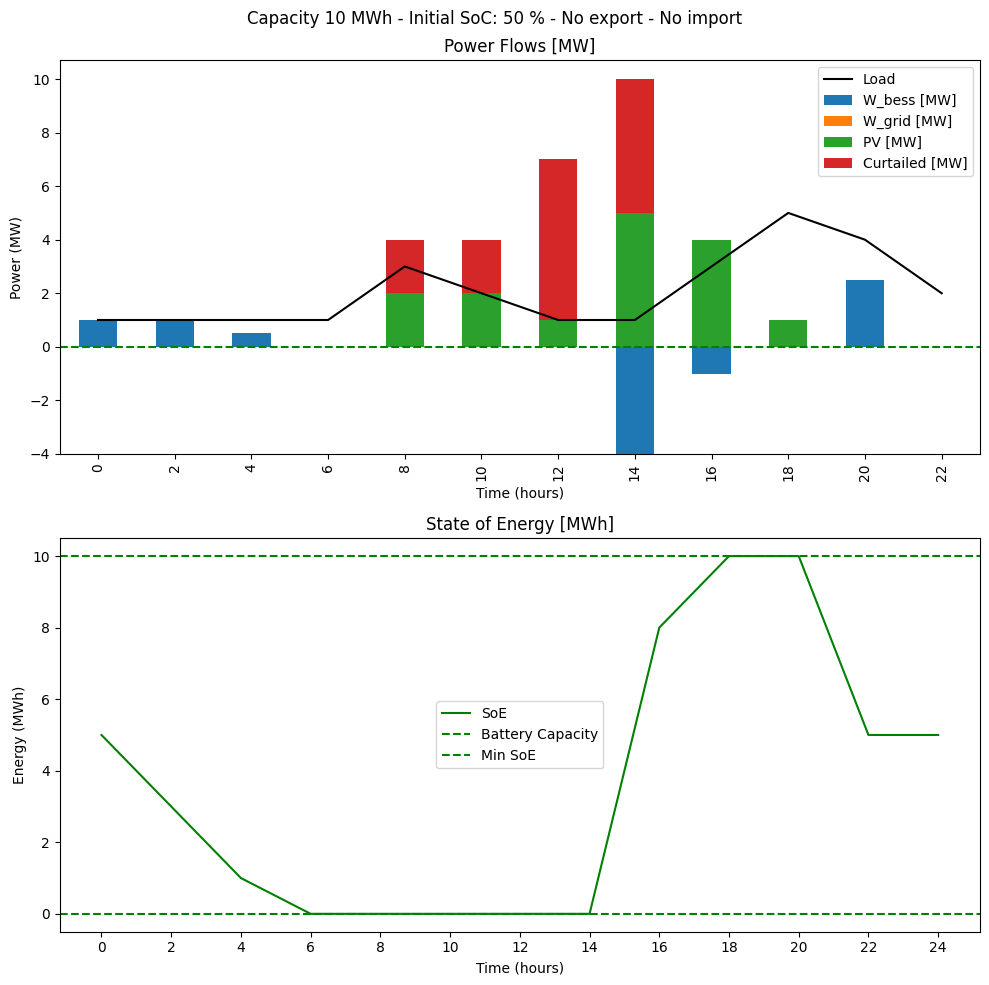

<Figure size 640x480 with 0 Axes>

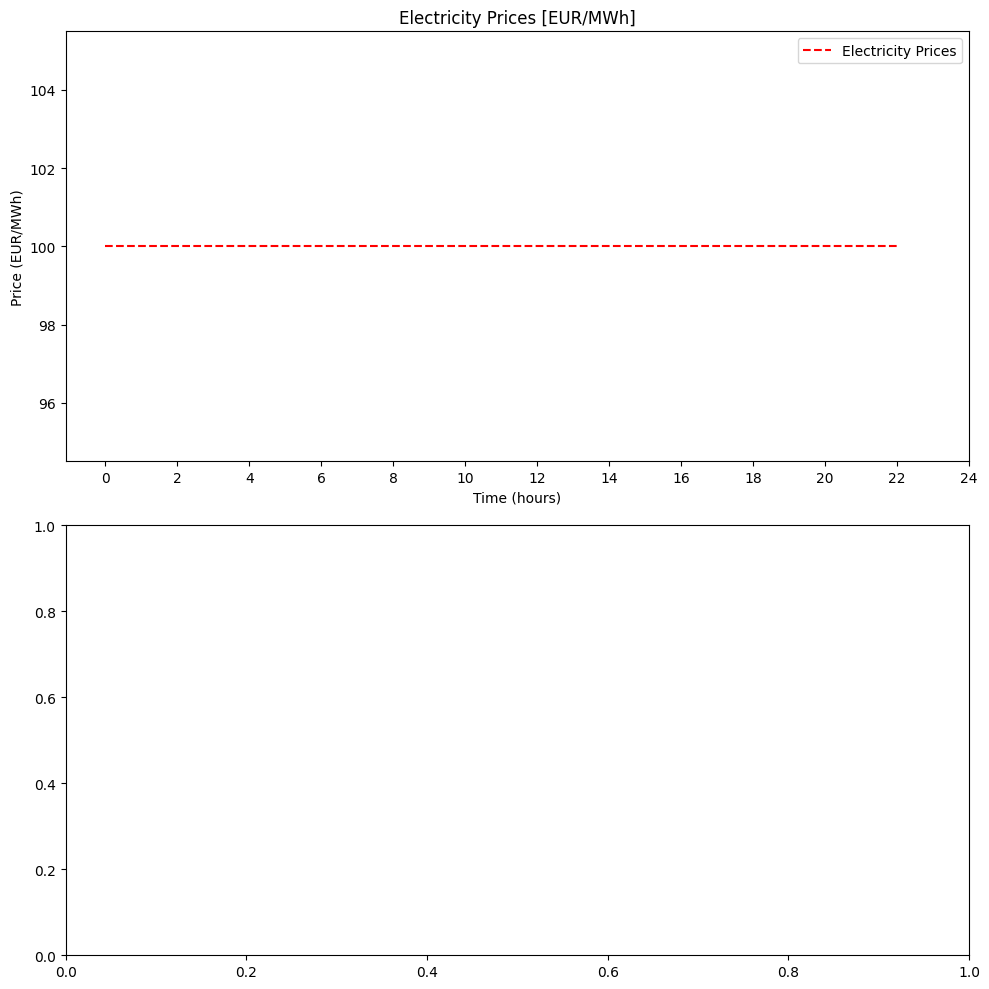

Cost: 200000.00 EUR
Import from the grid: 0.00 MWh
Export to the grid = 0.00 MWh
Energy curtailed: 30.00 MWh
Load not served: 12.00 MWh
SoE initial: 5.00 MWh, final: 5.00 MWh


---------------------------
Cost:  200000.0


In [ ]:
import logging
import pandas as pd
import pyomo
import pyomo.opt
import pyomo.environ as pe
import matplotlib.pyplot as plt

class PlantModelLinear:
    
    """
    A class to represent a linear plant model for optimizing the operation of a photovoltaic (PV) and battery energy storage system (BESS).
    Attributes
    ----------
    period : int
        The time period in hours for each time step.
    electricity_price : list
        The forecasted electricity prices in EUR/MWh for each time step.
    pv_forecast : list
        The forecasted PV generation in MW for each time step.
    load_forecast : list
        The forecasted load in MW for each time step.
    battery_capacity : float
        The capacity of the battery in MWh.
    battery_max_charge : float
        The maximum charging power of the battery in MW.
    battery_max_discharge : float
        The maximum discharging power of the battery in MW.
    battery_initial_charge : float
        The initial state of charge of the battery in MWh.
    no_grid_export : bool
        Flag to indicate if grid export is not allowed.
    no_grid_import : bool
        Flag to indicate if grid import is not allowed.
    no_load_shedding : bool
        Flag to indicate if load shedding is not allowed.
    last_results : pyomo.opt.SolverResults
        The results of the last optimization run.
    Methods
    -------
    __init__(self, pv_forecast_MW, load_forecast_MW, electricity_price_eur_MWh, battery_capacity_MWh, battery_max_charge_MW, battery_max_discharge_MW, battery_initial_charge_MWh, no_grid_export, no_grid_import, no_load_shedding):
        Initializes the PlantModelLinear with the given parameters.
    init_model(self):
        Initializes the Pyomo model with the given parameters.
    createModel(self):
        Creates the Pyomo model with variables, objective function, and constraints.
    solve(self):
        Solves the Pyomo model using the GLPK solver.
    display_results(self):
        Displays the results of the optimization using Matplotlib.

    """

    def __init__(self,
        pv_forecast_MW=[0,0,0,0,2,4,8,6,4,1,0,0],
        load_forecast_MW=[1,1,1,1,3,2,1,1,3,5,4,2],
        electricity_price_eur_MWh=[100,100,100,100,100,100,100,100,100,100,100,100],
        battery_capacity_MWh=20,
        battery_max_charge_MW=10,
        battery_max_discharge_MW=10,
        battery_initial_charge_MWh=10,
        no_grid_export=False,
        no_grid_import=False,
        no_load_shedding=False,
        ):
        assert len(pv_forecast_MW) == 12
        assert len(load_forecast_MW) == 12
        assert len(electricity_price_eur_MWh) == 12
        assert battery_capacity_MWh > 0
        assert battery_max_charge_MW > 0
        assert battery_max_discharge_MW > 0
        assert battery_initial_charge_MWh >= 0
        assert battery_initial_charge_MWh <= battery_capacity_MWh
        assert sum(load_forecast_MW) == sum(pv_forecast_MW), f"{sum(load_forecast_MW), sum(pv_forecast_MW)}"
        self.period = 2 #hours
        self.electricity_price = electricity_price_eur_MWh
        self.pv_forecast = pv_forecast_MW
        self.load_forecast = load_forecast_MW
        self.battery_capacity = battery_capacity_MWh
        self.battery_max_charge = battery_max_charge_MW
        self.battery_max_discharge = battery_max_discharge_MW
        self.battery_initial_charge = battery_initial_charge_MWh
        self.no_grid_export = no_grid_export
        self.no_grid_import = no_grid_import
        self.no_load_shedding = no_load_shedding
        self.last_results = None

        self.createModel()

    def init_model(self):
        """Initialize the pyomo model."""
        self.m = pe.ConcreteModel()

        self.m.period = self.period
        self.m.battery_capacity = self.battery_capacity
        self.m.battery_max_charge = self.battery_max_charge
        self.m.battery_max_discharge = self.battery_max_discharge
        self.m.battery_initial_charge = self.battery_initial_charge


        # Create sets
        self.m.time = pe.RangeSet(12)
        self.m.electricity_prices = pe.Param(self.m.time, initialize={t: self.electricity_price[t-1] for t in self.m.time})
        self.m.pv_forecast = pe.Param(self.m.time, initialize={t: self.pv_forecast[t-1] for t in self.m.time})
        self.m.load_forecast = pe.Param(self.m.time, initialize={t: self.load_forecast[t-1] for t in self.m.time})
    
    def createModel(self):
        """Create the pyomo model."""
        self.init_model()

        # Create variables
        self.m.SoE = pe.Var(self.m.time, bounds=(0, self.battery_capacity)) # end of period
        self.m.W_bess = pe.Var(self.m.time, bounds=(-self.battery_max_charge, self.battery_max_discharge))
        self.m.W_grid = pe.Var(self.m.time, bounds=(0 if self.no_grid_export else None, 0 if self.no_grid_import else None))
        self.m.W_pv = pe.Var(self.m.time, bounds=(0, None))
        self.m.W_load = pe.Var(self.m.time, bounds=(0, None))
        self.m.W_load_curtailed = pe.Var(self.m.time, bounds=(0, 0 if self.no_load_shedding else None))

        # Create objective
        def obj_rule(m):
            # Free PV energy, cost of grid energy. No transaction cost.
            return sum(m.electricity_prices[t] * m.W_grid[t] * m.period for t in m.time) + sum(m.W_load_curtailed[t] * 100*m.electricity_prices[t] * m.period for t in m.time)
        self.m.OBJ = pe.Objective(rule=obj_rule, sense=pe.minimize)
        
        
        def energy_balance_rule(m, t):
            # W_grid + W_pv + W_bess + W_grid = load_forecast
            return m.W_grid[t] + m.W_pv[t] + m.W_bess[t]  == self.m.W_load[t]
        self.m.EnergyBalance = pe.Constraint(self.m.time, rule=energy_balance_rule)

        def load_curtailable(m, t):
            return m.W_load[t] +m.W_load_curtailed[t]== m.load_forecast[t]
        self.m.PenalizeLoadCurtailed = pe.Constraint(self.m.time, rule=load_curtailable)

        # limited PV resource
        def upper_bound_pv(m,t):
            return m.W_pv[t] <= m.pv_forecast[t]
        
        self.m.UpperBoundPV = pe.Constraint(self.m.time, rule=upper_bound_pv)

        def battery_energy_balance(m, t):
            if t == 1:
                return m.SoE[t] == m.battery_initial_charge - m.W_bess[t]*m.period
            else:
                return m.SoE[t] == m.SoE[t-1] - m.W_bess[t]*m.period
        self.m.BatteryEnergyBalance = pe.Constraint(self.m.time, rule=battery_energy_balance)

        def battery_in_same_state_next_day(m):
            return m.SoE[12] == m.battery_initial_charge
        self.m.BatteryInSameStateNextDay = pe.Constraint(rule=battery_in_same_state_next_day)

    def solve(self):
        """Solve the model."""
        solver = pyomo.opt.SolverFactory('glpk')
        results = solver.solve(self.m, tee=True, keepfiles=False, options_string="mipgap=0.01")

        if (results.solver.status != pyomo.opt.SolverStatus.ok):
            logging.warning('Check solver not ok?')
        if (results.solver.termination_condition != pyomo.opt.TerminationCondition.optimal):  
            logging.warning('Check solver optimality?')

        self.last_results = results

    def display_results(self):
        """ Matplotlib result
        - one chart with power flows (PV productible (yellow dashed), PV( yellow), Load(red, épais), Battery(green), Grid (blue))
        - one chart with SoE (green) and battery capacity (green, dashed)
        - one chart with electricity prices (red dashed)
        - title: cost, total energy exchanged with the grid, total energy stored in the battery, energy curtailed
        """


        time = range(0, 24, 2)
        SoE = [self.battery_initial_charge]+ [pe.value(self.m.SoE[i+1]) for i in range(12)]
        

        W_bess = [pe.value(self.m.W_bess[i+1]) for i in range(12)]
        W_grid = [pe.value(self.m.W_grid[i+1]) for i in range(12)]
        W_pv = [pe.value(self.m.W_pv[i+1]) for i in range(12)]
        W_curtailed = [max(0, self.pv_forecast[i] - W_pv[i-1]) for i in range(12)]
        W_load = [self.load_forecast[i] for i in range(12)]
        
        electricity_prices = [self.electricity_price[i] for i in range(12)]

        powers = pd.DataFrame(index=time,
                data={'W_bess [MW]': W_bess,
                        'W_grid [MW]': W_grid,
                        'PV [MW]': W_pv,
                        'Curtailed [MW]': W_curtailed})
        

        plt.show()

        fig, axs = plt.subplots(2, 1, figsize=(10, 10))
        
        title_parts = ["Capacity {:.0f} MWh - Initial SoC: {:.0f} %".format(self.battery_capacity,self.battery_initial_charge/self.battery_capacity*100)]
        if self.no_grid_export:
            title_parts.append('No export')
        if self.no_grid_import:
            title_parts.append('No import')
        fig_title = ' - '.join(title_parts)
        fig.suptitle(fig_title)

        # Power flows
        powers.plot(kind="bar", stacked=True, ax=axs[0])
        # powers.sum(axis=1).plot(ax=axs[0], color="k", label="Load [MW]")
        axs[0].plot( W_load, color='k', label='Load')
        axs[0].axhline(y=0, color='g', linestyle='--')
        title_parts = ['Power Flows [MW]']
        axs[0].set_title('Power Flows [MW]')
        axs[0].set_xlabel('Time (hours)')
        axs[0].set_ylabel('Power (MW)')
        axs[0].legend()

        # State of Energy (SoE)
        axs[1].plot(range(0,26,2), SoE, 'g', label='SoE')
        axs[1].axhline(y=self.battery_capacity, color='g', linestyle='--', label='Battery Capacity')
        axs[1].axhline(y=0, color='g', linestyle='--', label='Min SoE')
        axs[1].xaxis.set_ticks(range(0,26,2))
        axs[1].set_title('State of Energy [MWh]')
        axs[1].set_xlabel('Time (hours)')
        axs[1].set_ylabel('Energy (MWh)')
        axs[1].legend()

        plt.tight_layout()
        plt.show()
        plt.savefig(fig_title+'.png')
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))
        # Electricity prices
        axs[0].plot(time, electricity_prices, 'r--', label='Electricity Prices')
        axs[0].xaxis.set_ticks(range(0,26,2))
        axs[0].set_title('Electricity Prices [EUR/MWh]')
        axs[0].set_xlabel('Time (hours)')
        axs[0].set_ylabel('Price (EUR/MWh)')
        axs[0].legend()

        plt.tight_layout()
        plt.show()

        total_cost = pe.value(self.m.OBJ)
        import_from_grid = sum(max(0, -self.m.W_grid[i+1].value) for i in range(12)) * self.period
        export_to_grid = sum(max(0, self.m.W_grid[i+1].value) for i in range(12)) * self.period
        pv_curtailed = sum(max(0, self.pv_forecast[i] - W_pv[i-1]) for i in range(12)) * self.period
        load_curtailed = sum(max(0, self.load_forecast[i] - W_load[i-1]) for i in range(12)) * self.period

        print(f'Cost: {total_cost:.2f} EUR')
        print(f'Import from the grid: {import_from_grid:.2f} MWh')
        print(f'Export to the grid = {export_to_grid:.2f} MWh')
        print(f'Energy curtailed: {pv_curtailed:.2f} MWh')
        print(f'Load not served: {load_curtailed:.2f} MWh')
        print(f'SoE initial: {SoE[0]:.2f} MWh, final: {SoE[-1]:.2f} MWh')



if __name__ == '__main__':
    sp = PlantModelLinear(battery_capacity_MWh=10, battery_initial_charge_MWh=5, no_grid_export=False, no_grid_import=False )
    sp = PlantModelLinear(battery_capacity_MWh=10, battery_initial_charge_MWh=5, no_grid_export=True, no_grid_import=False )
    sp = PlantModelLinear(battery_capacity_MWh=10, battery_initial_charge_MWh=5, no_grid_export=True, no_grid_import=True )
    #sp = PlantModelLinear(battery_capacity_MWh=40, battery_initial_charge_MWh=20, no_grid_export=True, no_grid_import=True )
    sp.solve()
    sp.display_results()
    print('\n\n---------------------------')
    print('Cost: ', sp.m.OBJ())